# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')
# Load in the feature summary file.
features_sum = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')



> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [3]:
features_sum['missing_or_unknown'].value_counts()

missing_or_unknown
[-1]        26
[-1,9]      17
[-1,0]      16
[0]         12
[]          10
[-1,0,9]     1
[-1,X]       1
[XX]         1
[-1,XX]      1
Name: count, dtype: int64

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print("AZDIAS Dataset:")
print(f"Number of rows: {azdias.shape[0]}, Number of columns: {azdias.shape[1]}")
print("\nColumn Names:")
print(azdias.columns)
print("\nFeature Summary Dataset:")
print(f"Number of rows: {features_sum.shape[0]}, Number of columns: {features_sum.shape[1]}")
print("\nColumn Names:")
print(features_sum.columns)




AZDIAS Dataset:
Number of rows: 891221, Number of columns: 85

Column Names:
Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ

In [5]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [6]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,817722.000000,891221.000000,891221.000000,817722.000000,817722.000000,817722.000000,872873.000000,306609.000000,783619.000000,817722.000000,798073.000000,794213.000000,798073.000000,817252.000000,798073.000000,798073.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,797481.000000,797481.000000,797481.000000,798066.000000,770025.000000,757897.000000,886367.000000,770025.000000,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,1101.178533,7.350304,0.196612,1.792102,14.622637,4.453621,3.599574,2.185966,4.791151,2.432575,1.026827,8.154346,3.419630,3.945860,4.272729,4.240609,4.001597,4.023709,4.359086,4.481405,4.025014,3.910139,4.763223,4.667550,4.445007,4.256076,3.661784,1.266967,0.008423,0.003483,1.197852,3.362438,10.864126,1.727637,0.004162,4.207243,3.410640,3.933406,7.908791,8.287263,0.040647,2.798641,3.018452,1993.277011,4.052836,1.494277,1.265584,0.624525,0.305927,1.389552,3.158580,4.153043,3.939172,4.549491,3.738306,2.592991,2.963540,2.698691,4.257967,619.701439,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,976.583551,3.525723,0.397437,1.269062,12.616883,3.855639,3.926486,1.756537,3.425305,1.474315,0.586634,4.844532,1.417741,1.946564,1.915885,2.007373,1.857540,2.077746,2.022829,1.807552,1.903816,1.580306,1.830789,1.795712,1.852412,1.770137,1.707637,1.287435,0.091392,0.084957,0.952532,1.352704,7.639683,1.155849,0.068855,1.624057,1.628844,1.964701,1.923137,15.628087,0.324028,2.656713,1.550312,3.332739,1.949539,1.403961,1.245178,1.013443,0.638725,1.779483,1.329537,2.183710,1.718996,2.028919,0.923193,1.119052,1.428882,1.521524,2.030385,340.034318,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000

In [7]:
features_sum.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [8]:
# Identify missing or unknown data values and convert them to NaNs.
import json
features_sum['missing_or_unknown'] = features_sum['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))

for attribute, missing_array in zip(features_sum['attribute'], features_sum['missing_or_unknown']):
    # it's not an empty array
    if(missing_array[0] != ''):
        idx = 0
        for missing_value in missing_array:
            if(missing_value.isnumeric()or missing_value.lstrip('-').isnumeric()):
                missing_value = int(missing_value)
            azdias.loc[azdias[attribute] == missing_value, attribute] = np.nan








In [9]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2.0,6.0,7.0,5.0,1.0,5.0,3.0,3.0,4.0,7.0,6.0,6.0,5.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,3.0,1.0,NaN,2.0,5.0,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,2.0,0.0,NaN,1.0,5.0,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,1.0,0.0,NaN,1.0,3.0,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,2.0,0.0,NaN,2.0,4.0,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [10]:
print(f'The total number of missing data in the dataset is : {azdias.isnull().sum().sum()}')

The total number of missing data in the dataset is : 8373929


In [11]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

attributes = list(azdias.columns)
count_percentage_missing_values = []
for att in attributes:
    count_percentage_missing_values.append(azdias[att].isnull().sum()/len(azdias)*100)



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


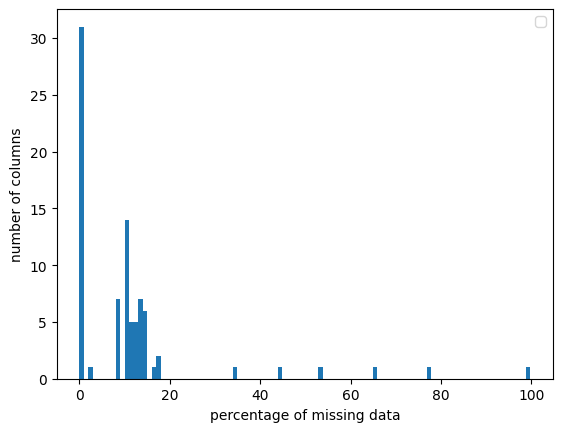

In [12]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(count_percentage_missing_values, bins=100)
plt.xlabel('percentage of missing data')
plt.ylabel('number of columns')
plt.legend()
plt.show()



In [13]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
count_percentage_missing_values = np.array(count_percentage_missing_values)
attributes = np.array(attributes)
outliers_percentage = count_percentage_missing_values[count_percentage_missing_values > 20]
outliers_idx = np.where(count_percentage_missing_values > 20)
outliers_columns_name = attributes[outliers_idx]
outliers_percentage, outliers_columns_name



(array([76.9554353 , 44.02028229, 99.75763587, 34.81369941, 65.59674873,
        53.46866827]),
 array(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
        'KBA05_BAUMAX'], dtype='<U21'))

#### Discussion 1.1.2: Assess Missing Data in Each Column

After analyzing the percentage of missing data in each column, we noticed that the majority of columns have a missing data percentage below 20%. However, six columns exceed this threshold, with percentages ranging from 34% to nearly 100%. These columns are considered significant outliers due to the high percentage of missing values. As a result, we decided to drop these columns to improve data quality and reduce noise in subsequent analyses.

The columns removed due to high missing data percentages are: 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', and 'KBA05_BAUMAX'.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [14]:
# How much data is missing in each row of the dataset?
number_missing_row = azdias.isnull().sum(axis=1)
percentage_missing_row = number_missing_row/ azdias.shape[1] *100



number_missing_row.head(5)

0    49
1     4
2     4
3     9
4     3
dtype: int64

In [15]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
Number = 10

subset_above_threshold = azdias[percentage_missing_row > Number]
subset_below_threshold = azdias[percentage_missing_row < Number]




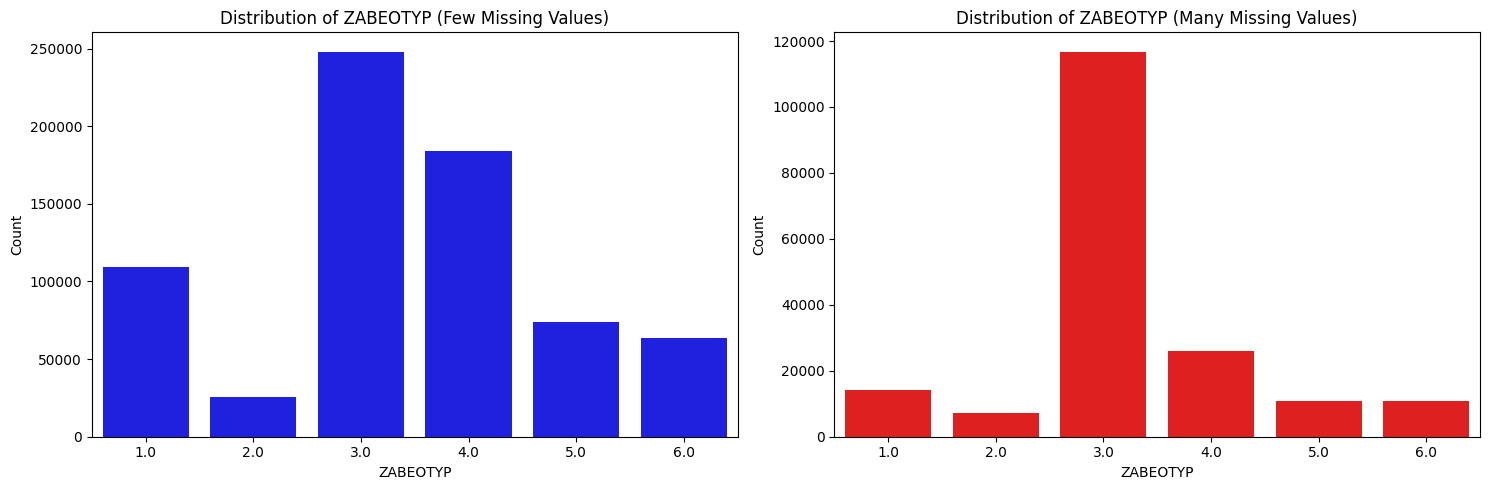

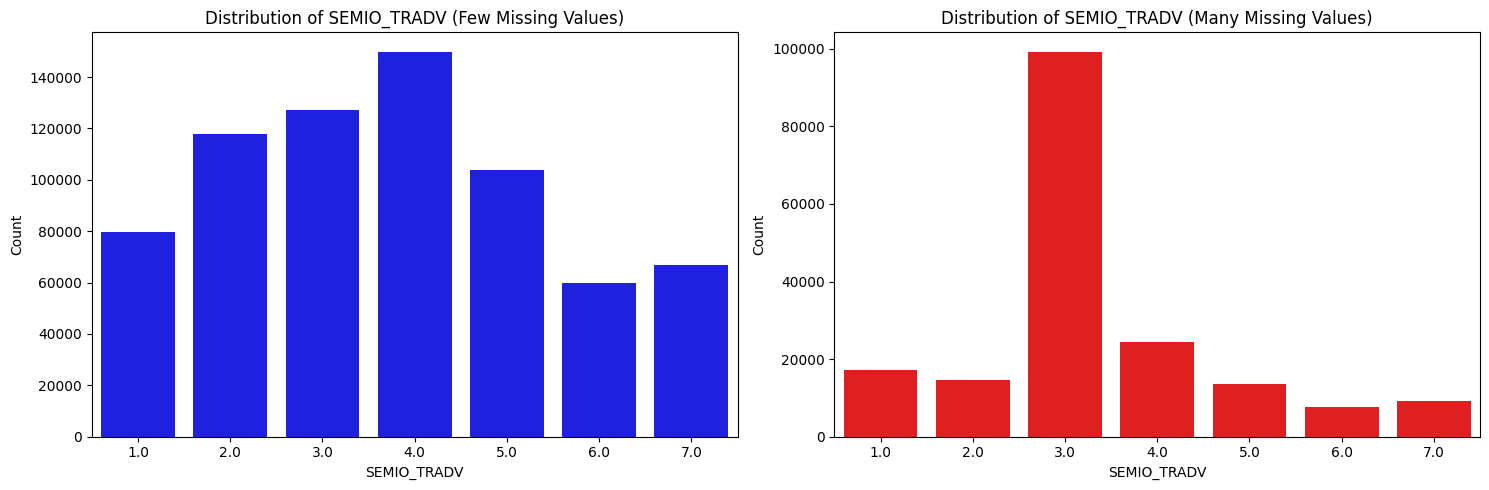

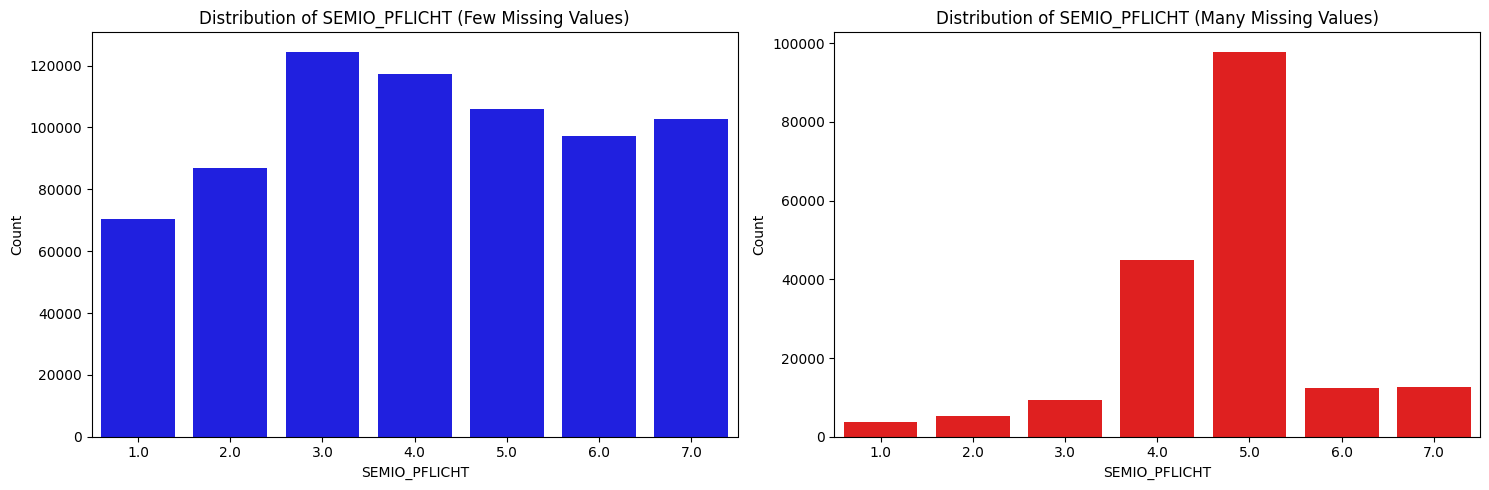

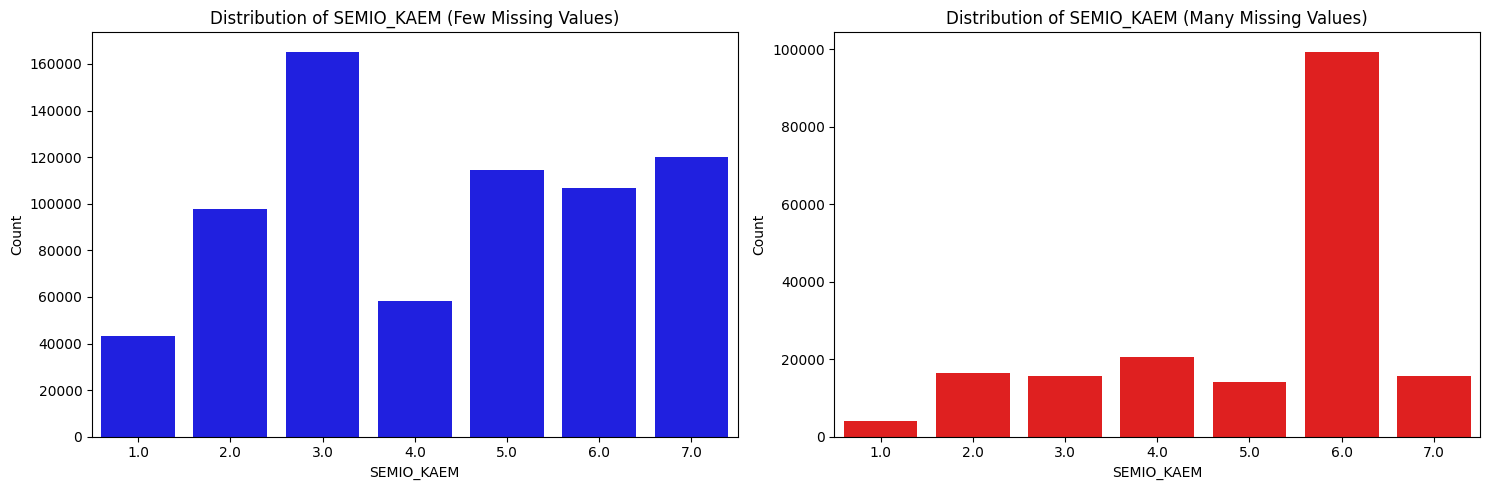

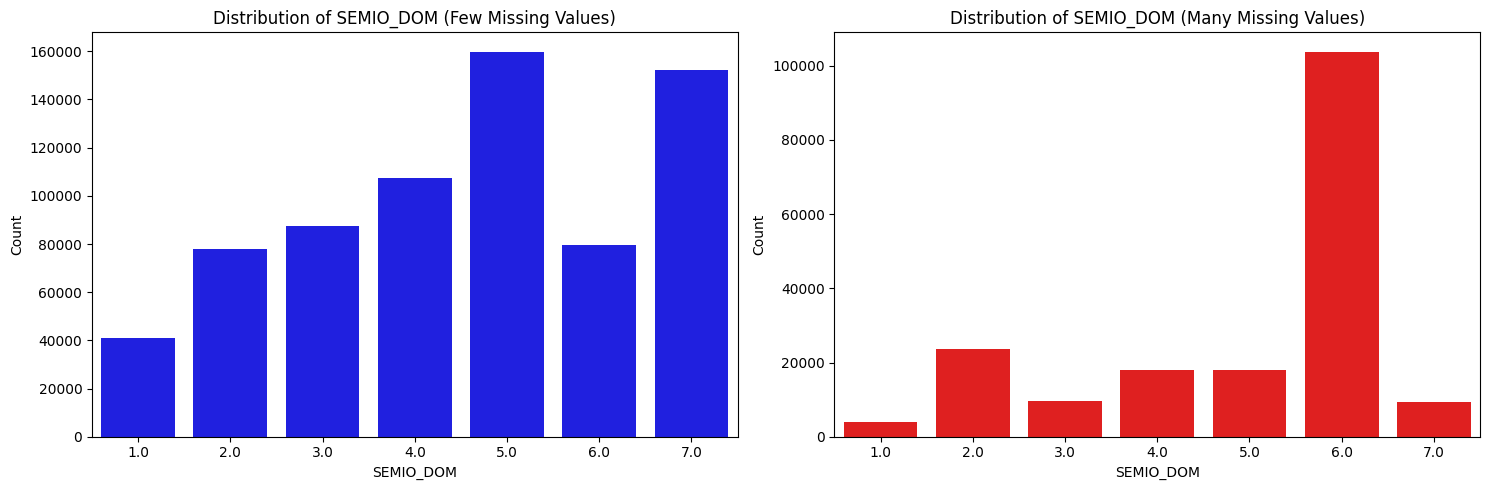

In [16]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
five_col = np.argsort(count_percentage_missing_values)[:5]
five_columns = attributes[five_col]

# Plot the distributions for each of the selected columns
for feature in five_columns:
    plt.figure(figsize=(15, 5))

    # Plot for subset with few or no missing values
    plt.subplot(1, 2, 1)
    sns.countplot(data=subset_below_threshold, x=feature, color="blue")
    plt.title(f"Distribution of {feature} (Few Missing Values)")
    plt.xlabel(feature)
    plt.ylabel("Count")

    # Plot for subset with many missing values
    plt.subplot(1, 2, 2)
    sns.countplot(data=subset_above_threshold, x=feature, color="red")
    plt.title(f"Distribution of {feature} (Many Missing Values)")
    plt.xlabel(feature)
    plt.ylabel("Count")

    plt.tight_layout()
    plt.show()

#### Discussion 1.1.3: Assess Missing Data in Each Row

With a threshold of 10%, we observed significant differences in the distribution of data between rows with many missing values and those with few or no missing values. Rows with excessive missing data tend to exhibit inconsistent patterns that could skew the results or introduce bias. To ensure the reliability of our analysis and maintain data integrity, I have decided to remove these rows with high levels of missing data. This approach prioritizes the quality of the dataset over quantity, reducing potential noise and enhancing the robustness of the analysis.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [17]:
# How many features are there of each data type?
feat_info = features_sum.drop(features_sum[features_sum['attribute'].isin(outliers_columns_name)].index)
feat_info['type'].value_counts()





type
ordinal        49
categorical    18
mixed           6
numeric         6
Name: count, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [18]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
new_azdias = subset_below_threshold
categorical_features = feat_info[feat_info['type'] == 'categorical']['attribute']
categorical_data = new_azdias[categorical_features]
categorical_data.head(5)



,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
1,2.0,5.0,1.0,10.0,0,5.0,3.0,2.0,1.0,1.0,3.0,1.0,2.0,5.0,8.0,W,8,8A
2,2.0,3.0,1.0,10.0,1,1.0,1.0,3.0,2.0,1.0,2.0,0.0,1.0,5.0,1.0,W,4,4C
4,1.0,5.0,5.0,5.0,0,10.0,5.0,3.0,2.0,1.0,2.0,0.0,2.0,4.0,1.0,W,6,6B
5,2.0,2.0,2.0,1.0,0,1.0,1.0,4.0,2.0,1.0,0.0,0.0,2.0,4.0,1.0,W,8,8C
6,2.0,5.0,4.0,12.0,0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,4.0,1.0,W,4,4A


In [19]:
# Re-encode categorical variable(s) to be kept in the analysis.
from pandas.api.types import is_string_dtype

# Store categorical features to encode or drop
features_to_encode = []
features_to_drop = []

# Iterate through the categorical features
for feature in categorical_features:
    d = categorical_data[feature]

    if d.nunique() == 2:
        # For binary variables, check if it's numeric or non-numeric
        if not is_string_dtype(d.dtype):
            print(f'++ Keeping {feature} with {d.nunique()} values, type: {d.dtype} without re-encoding')
        else:
            # For non-numeric binary variables, re-encode them
            features_to_encode.append(feature)
            print(f'++ Re-encoding {feature} with {d.nunique()} values, type: {d.dtype}')
    elif 3 <= d.nunique() <= 5:
        # For multi-level categoricals with 3 to 5 unique values, encode
        features_to_encode.append(feature)
        print(f'++ Re-encoding {feature} with {d.nunique()} values, type: {d.dtype}')
    else:
        # For multi-level categoricals with more than 5 unique values, drop
        features_to_drop.append(feature)
        print(f'-- Dropping {feature} with {d.nunique()} values, type: {d.dtype}')

# Display the features to encode or drop
print("Features to encode:", features_to_encode)
print("Features to drop:", features_to_drop)


++ Keeping ANREDE_KZ with 2 values, type: float64 without re-encoding
-- Dropping CJT_GESAMTTYP with 6 values, type: float64
-- Dropping FINANZTYP with 6 values, type: float64
-- Dropping GFK_URLAUBERTYP with 12 values, type: float64
++ Keeping GREEN_AVANTGARDE with 2 values, type: int64 without re-encoding
-- Dropping LP_FAMILIE_FEIN with 11 values, type: float64
++ Re-encoding LP_FAMILIE_GROB with 5 values, type: float64
-- Dropping LP_STATUS_FEIN with 10 values, type: float64
++ Re-encoding LP_STATUS_GROB with 5 values, type: float64
++ Re-encoding NATIONALITAET_KZ with 3 values, type: float64
++ Re-encoding SHOPPER_TYP with 4 values, type: float64
++ Keeping SOHO_KZ with 2 values, type: float64 without re-encoding
++ Keeping VERS_TYP with 2 values, type: float64 without re-encoding
-- Dropping ZABEOTYP with 6 values, type: float64
-- Dropping GEBAEUDETYP with 7 values, type: float64
++ Re-encoding OST_WEST_KZ with 2 values, type: object
-- Dropping CAMEO_DEUG_2015 with 9 values, ty

In [20]:
print(f'We will re-encode these categorical features: {features_to_encode}') 
print(f'Features to drop: {features_to_drop}')

new_azdias = new_azdias.drop(columns=features_to_drop)

# Re-encode categorical features and add them back to the DataFrame
for feature in features_to_encode:
    dummies = pd.get_dummies(new_azdias[feature], prefix=feature)  
    new_azdias = new_azdias.drop(columns=[feature])  
    new_azdias = pd.concat([new_azdias, dummies], axis=1) 

new_azdias.head(5)

We will re-encode these categorical features: ['LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'OST_WEST_KZ']
Features to drop: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,TITEL_KZ,VERS_TYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,OST_WEST_KZ_O,OST_WEST_KZ_W
1,NaN,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,1996.0,0,3.0,21.0,6.0,14.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,1.0,NaN,2.0,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,1.0,1992.0,4.0,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,True
2,NaN,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1979.0,1,3.0,3.0,1.0,15.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,0.0,NaN,1.0,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,5.0,1992.0,2.0,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,True
4,NaN,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,1963.0,0,3.0,32.0,10.0,8.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,0.0,NaN,2.0,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,4.0,1992.0,3.0,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,True,False,False,True
5,3.0,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,1943.0,0,3.0,8.0,2.0,3.0,3.0,2.0,4.0,7.0,4.0,2.0,2.0,2.0,5.0,7.0,4.0,4.0,4.0,7.0,6.0,0.0,NaN,2.0,10.0,1.0,0.0,5.0,3.0,6.0,9.0,5.0,0.0,5.0,1992.0,7.0,54,2.0,2.0,0.0,0.0,NaN,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,True,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,True
6,NaN,2.0,2.0,1.0,5.0,1.0,5.0,4.0,3.0,NaN,0,2.0,2.0,1.0,10.0,4.0,2.0,5.0,5.0,7.0,2.0,6.0,5.0,5.0,7.0,7.0,4.0,7.0,7.0,7.0,0.0,NaN,1.0,NaN,1.0,0.0,6.0,NaN,3.0,9.0,4.0,0.0,5.0,1992.0,5.0,22,3.0,2.0,0.0,0.0,1.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0,True,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,True


#### Discussion 1.2.1: Re-Encode Categorical Features

In this step, I evaluated the categorical features in the dataset and made decisions based on their number of unique values and data types. I kept binary variables with numeric values, such as ANREDE_KZ and SOHO_KZ, without any modifications. For the binary non-numeric variable OST_WEST_KZ, I re-encoded the values 'O' and 'W' as 0 and 1. Multi-level categorical features with fewer than 5 unique values were re-encoded using one-hot encoding, while those with more than 5 unique values were dropped to prevent unnecessary complexity in the analysis. This approach ensured that the categorical data was in a suitable format for analysis and machine learning while maintaining the dataset's efficiency.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [21]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
mainstream = [1,3,5,8,10,12,14]
avantgarde =  [2,4, 6,7, 9, 11, 13, 15]
def get_movement(m):
    if(m in mainstream):
        return 0
    elif(m in avantgarde):
        return 1
    else:
        return m

new_azdias['MOUVEMENT'] = new_azdias['PRAEGENDE_JUGENDJAHRE'].apply(get_movement)

decade = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
new_azdias['DECADE'] = new_azdias['PRAEGENDE_JUGENDJAHRE'] 
new_azdias['DECADE'].replace(decade, inplace=True)

new_azdias.head(4)





,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,TITEL_KZ,VERS_TYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,OST_WEST_KZ_O,OST_WEST_KZ_W,MOUVEMENT,DECADE
1,NaN,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,1996.0,0,3.0,21.0,6.0,14.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,1.0,NaN,2.0,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,1.0,1992.0,4.0,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,True,0.0,6.0
2,NaN,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1979.0,1,3.0,3.0,1.0,15.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,0.0,NaN,1.0,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,5.0,1992.0,2.0,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,True,1.0,6.0
4,NaN,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,1963.0,0,3.0,32.0,10.0,8.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,0.0,NaN,2.0,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,4.0,1992.0,3.0,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,True,False,False,True,0.0,4.0
5,3.0,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,1943.0,0,3.0,8.0,2.0,3.0,3.0,2.0,4.0,7.0,4.0,2.0,2.0,2.0,5.0,7.0,4.0,4.0,4.0,7.0,6.0,0.0,NaN,2.0,10.0,1.0,0.0,5.0,3.0,6.0,9.0,5.0,0.0,5.0,1992.0,7.0,54,2.0,2.0,0.0,0.0,NaN,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,True,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,True,0.0,2.0


In [22]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
wealth = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
           '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
           '51':5, '52':5, '53':5, '54':5, '55':5}
life_stage = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5}

# copy the values
new_azdias['WEALTH'] = new_azdias['CAMEO_INTL_2015']
new_azdias['LIFE_STAGE'] = new_azdias['CAMEO_INTL_2015']

new_azdias['WEALTH'].replace(wealth, inplace=True)
new_azdias['LIFE_STAGE'].replace(life_stage, inplace=True)



#### Discussion 1.2.2: Engineer Mixed-Type Features

In this step, I focused on transforming and splitting the mixed-type features 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' to make them more useful for analysis. For 'PRAEGENDE_JUGENDJAHRE', I created two new variables: one representing the decade as an interval (e.g., 1960s, 1970s) and another indicating whether the individual belonged to the mainstream or avant-garde movement based on their formative years. For 'CAMEO_INTL_2015', I split the two-digit codes into two separate variables: 'WEALTH' and 'LIFE_STAGE', each mapped to numerical categories using dictionaries. I chose to drop other mixed-type features as they were either less relevant to the analysis or more complex to process effectively.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [23]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
mixed_features = feat_info.loc[feat_info['type'] == 'mixed', 'attribute']
new_azdias = new_azdias.drop(columns = mixed_features)



In [24]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.




### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [25]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    import json
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
    # remove [ ] and convert it to list
    feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))

    for attribute, missing_array in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
        # it's not an empty array
        if(missing_array[0] != ''):
            idx = 0
            for missing_value in missing_array:
                if(missing_value.isnumeric()or missing_value.lstrip('-').isnumeric()):
                    missing_value = int(missing_value)
                df.loc[df[attribute] == missing_value, attribute] = np.nan
    
    
    # remove selected columns and rows, ...
    outlier_columns = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df = df.drop(columns= outlier_columns)
    
    number_missing_data_each_row = df.isnull().sum(axis=1)
    percentage_missing_data_each_row = number_missing_data_each_row/ df.shape[1] *100

    threshold = 10

    outlire_rows = df[percentage_missing_data_each_row > threshold]
    normal_rows = df[percentage_missing_data_each_row < threshold]
    
    # continue with only the normal rows
    df = normal_rows
    #drop outlier columns from feat_info
    feat_info = feat_info.drop(feat_info[feat_info['attribute'].isin(outliers_columns_name)].index)

    categorical_features = feat_info[feat_info['type'] == 'categorical']['attribute']
    categorical_data = df[categorical_features]

    # store categrical features to encode
    features_to_encode = []
    features_to_drop = []
    for feature in categorical_features:
        d = categorical_data[feature]
        '''
            encode only binary variable of non-numerical values and
            multi-level categoricals with less than 5 categories 
        '''  
        if(d.nunique() == 2 and not is_string_dtype(d.dtype)):
            continue
        else:
            if((d.nunique()> 2 and d.nunique()< 5) or d.nunique() == 2 and is_string_dtype(d.dtype)):
                features_to_encode.append(feature)
            else:
                features_to_drop.append(feature)    
    
    df = df.drop(features_to_drop, axis=1)
    
    # convert categorical varibles to dummy varibles
    for feature in features_to_encode:
        dummies = pd.get_dummies(df[feature])
        df = df.drop(feature, axis=1)
        df = pd.concat([df, dummies], axis=1)
        
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    mainstream = [1,3,5,8,10,12,14]
    avantgarde =  [2,4, 6,7, 9, 11, 13, 15]
    def get_movement(m):
        if(m in mainstream):
            return 0
        elif(m in avantgarde):
            return 1
        else:
            return m

    df['MOUVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(get_movement)

    decade = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'] 
    df['DECADE'].replace(decade, inplace=True)

    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    wealth = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
           '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
           '51':5, '52':5, '53':5, '54':5, '55':5}
    life_stage = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5}

    # copy the values
    df['WEALTH'] = df['CAMEO_INTL_2015']
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015']

    df['WEALTH'].replace(wealth, inplace=True)
    df['LIFE_STAGE'].replace(life_stage, inplace=True)
    # Return the cleaned dataframe.
    
    mixed_features = feat_info.loc[feat_info['type'] == 'mixed', 'attribute']
    df = df.drop(mixed_features, axis=1)
    
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [26]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.impute import SimpleImputer

columns_name = new_azdias.columns

imputer = SimpleImputer()
new_azdias = pd.DataFrame(imputer.fit_transform(new_azdias), columns=columns_name)
new_azdias.head(4)





,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,TITEL_KZ,VERS_TYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,OST_WEST_KZ_O,OST_WEST_KZ_W,MOUVEMENT,DECADE,WEALTH,LIFE_STAGE
0,1.7225,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,1996.0,0.0,3.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,1.0,1.332222,2.0,15.269425,2.0,0.0,6.0,3.422525,3.0,9.0,11.0,0.0,1.0,1992.0,0.0,0.0,0.0,2.0,5.000000,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,6.0,5.0,1.0
1,1.7225,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1979.0,1.0,3.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,0.0,1.332222,1.0,17.000000,1.0,0.0,4.0,3.422525,3.0,9.0,10.0,0.0,5.0,1992.0,1.0,3.0,1.0,0.0,2.515274,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,5.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,6.0,2.0,4.0
2,1.7225,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,1963.0,0.0,3.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,0.0,1.332222,2.0,20.000000,4.0,0.0,5.0,1.000000,2.0,9.0,3.0,0.0,4.0,1992.0,1.0,4.0,1.0,0.0,2.515274,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,3.0,3.0,4.0,6.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,4.0,4.0,3.0
3,3.0000,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,1943.0,0.0,3.0,3.0,2.0,4.0,7.0,4.0,2.0,2.0,2.0,5.0,7.0,4.0,4.0,4.0,7.0,6.0,0.0,1.332222,2.0,10.000000,1.0,0.0,5.0,3.000000,6.0,9.0,5.0,0.0,5.0,1992.0,2.0,2.0,0.0,0.0,2.515274,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,5.0,4.0


In [27]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

new_azdias = pd.DataFrame(scaler.fit_transform(new_azdias), columns= columns_name)
new_azdias.head(4)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,TITEL_KZ,VERS_TYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,OST_WEST_KZ_O,OST_WEST_KZ_W,MOUVEMENT,DECADE,WEALTH,LIFE_STAGE
0,-1.270477e-15,-1.743760,0.969241,-1.522697,1.587980,-1.054319,1.520626,1.049358,1.334283,2.072081,-0.541528,1.051364,-1.658670,0.407154,-0.046424,0.041040,-0.431211,-1.716742,-1.117195,-1.432911,-0.588566,1.285456,-0.288797,1.317300,-0.148244,1.514629,1.270433,10.854269,1.288975e-14,0.952276,1.091654e-15,0.196600,-0.060542,0.995900,-1.320507e-15,-0.693454,0.546976,0.164967,-0.128804,-1.299267,-0.387589,-1.071326,-1.012221,-0.613331,2.661834,1.976490e+00,-1.629764,0.850558,-0.563170,1.710096,-0.799100,-0.765981,-1.385807,0.163658,-0.829341,1.029573,-0.252147,0.206510,0.396769,0.401699,1.431249,0.568416,-0.187156,-0.143277,0.674249,-1.034061,-0.381365,5.253264,-0.253445,-0.574420,1.210853,-0.529211,-0.227262,-0.470867,-0.412034,0.403173,-0.300194,-0.207379,-0.454977,-0.674603,-0.614935,1.864222,-0.525319,0.525319,-0.547493,1.159675,1.169581,-1.259397
1,-1.270477e-15,0.198296,0.969241,-1.522697,0.909142,-1.774657,-0.539744,0.321698,1.334283,0.868365,1.846626,1.051364,-0.284805,-0.105847,-1.616990,-0.491033,-0.431211,-0.147505,-0.163521,0.759975,-0.588566,0.084264,1.433979,1.317300,1.442061,-0.604446,-0.421672,-0.092130,1.288975e-14,-1.069262,5.317591e-01,-0.674875,-0.060542,-0.301199,-1.320507e-15,-0.693454,0.546976,0.100220,-0.128804,1.294919,-0.387589,-0.363817,1.405011,0.370077,-0.474181,-3.532534e-16,-0.124491,-0.976519,0.020101,-0.260114,0.289492,-0.765981,0.012309,-0.479427,-1.390313,0.284517,0.772703,0.206510,-0.616636,-0.969355,0.400073,0.568416,-0.187156,-0.143277,-0.804296,0.967061,-0.381365,-0.190358,-0.253445,-0.574420,-0.825864,1.889607,-0.227262,-0.470867,-0.412034,0.403173,-0.300194,-0.207379,-0.454977,-0.674603,1.626188,-0.536417,-0.525319,0.525319,1.844027,1.159675,-0.877992,0.752932
2,-1.270477e-15,0.198296,-1.031736,0.680489,0.230304,0.386356,-1.226533,0.321698,-0.841744,-0.264544,-0.541528,1.051364,1.089061,0.920155,-0.046424,0.041040,-0.948785,1.421732,-0.163521,-0.336468,0.935890,-1.116928,-0.863056,-1.405819,-1.208447,-0.074677,-0.985707,-0.092130,1.288975e-14,0.952276,1.453579e+00,1.939550,-0.060542,0.347350,-2.401140e+00,-1.272331,0.546976,-0.353009,-0.128804,0.646372,-0.387589,-0.363817,2.210755,0.370077,-0.474181,-3.532534e-16,-0.124491,-0.976519,0.603371,-1.737772,1.378083,0.284338,0.012309,1.449828,0.292603,-0.537717,-0.252147,1.293274,0.396769,0.401699,-0.631104,-0.330546,0.821146,0.292448,1.413522,-1.034061,-0.381365,-0.190358,-0.253445,1.740886,-0.825864,1.889607,-0.227262,-0.470867,-0.412034,0.403173,-0.300194,-0.207379,-0.454977,-0.674603,1.626188,-0.536417,-0.525319,0.525319,-0.547493,-0.215079,0.487056,0.082156
3,3.654749e+00,-1.743760,0.969241,-0.053906,-1.127372,1.106694,-0.539744,-0.405963,1.334283,-1.680681,-0.541528,1.051364,-0.284805,-1.131849,-0.046424,1.637259,0.086364,-1.193663,-1.117195,-1.432911,0.427738,1.886052,-0.288

### Discussion 2.1: Apply Feature Scaling

For this task, I applied the SimpleImputer to replace all missing values with the mean of each respective column, followed by normalizing the data using StandardScaler to ensure all features have a mean of 0 and a standard deviation of 1. This approach ensures that the features are on the same scale, which is crucial for algorithms sensitive to feature scaling.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [28]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()
pca.fit_transform(new_azdias)

array([[ 4.47968767e+00, -2.77333708e+00, -3.05383866e+00, ...,
        -1.44200495e-02, -1.28693517e-13,  2.16857322e-14],
       [-6.93875452e-01, -1.79907777e-01, -3.44489549e+00, ...,
        -1.04939573e-02, -2.42788768e-13,  8.80970976e-14],
       [ 1.54097877e-01, -2.51257730e-01,  2.59215728e+00, ...,
         1.21402845e-02,  5.72914807e-14,  5.76449497e-14],
       ...,
       [ 4.80268823e+00,  1.61756461e+00,  1.23483920e+00, ...,
        -1.22453015e-02, -1.93316410e-15, -1.97142261e-16],
       [ 5.65264591e+00, -3.59710097e+00,  2.75900830e+00, ...,
         5.67371723e-03,  9.73381273e-16, -1.95979254e-16],
       [-8.01797537e-02,  1.40037847e+00,  2.61846272e+00, ...,
        -2.63617344e-03, -4.05770418e-15, -4.31635170e-16]])

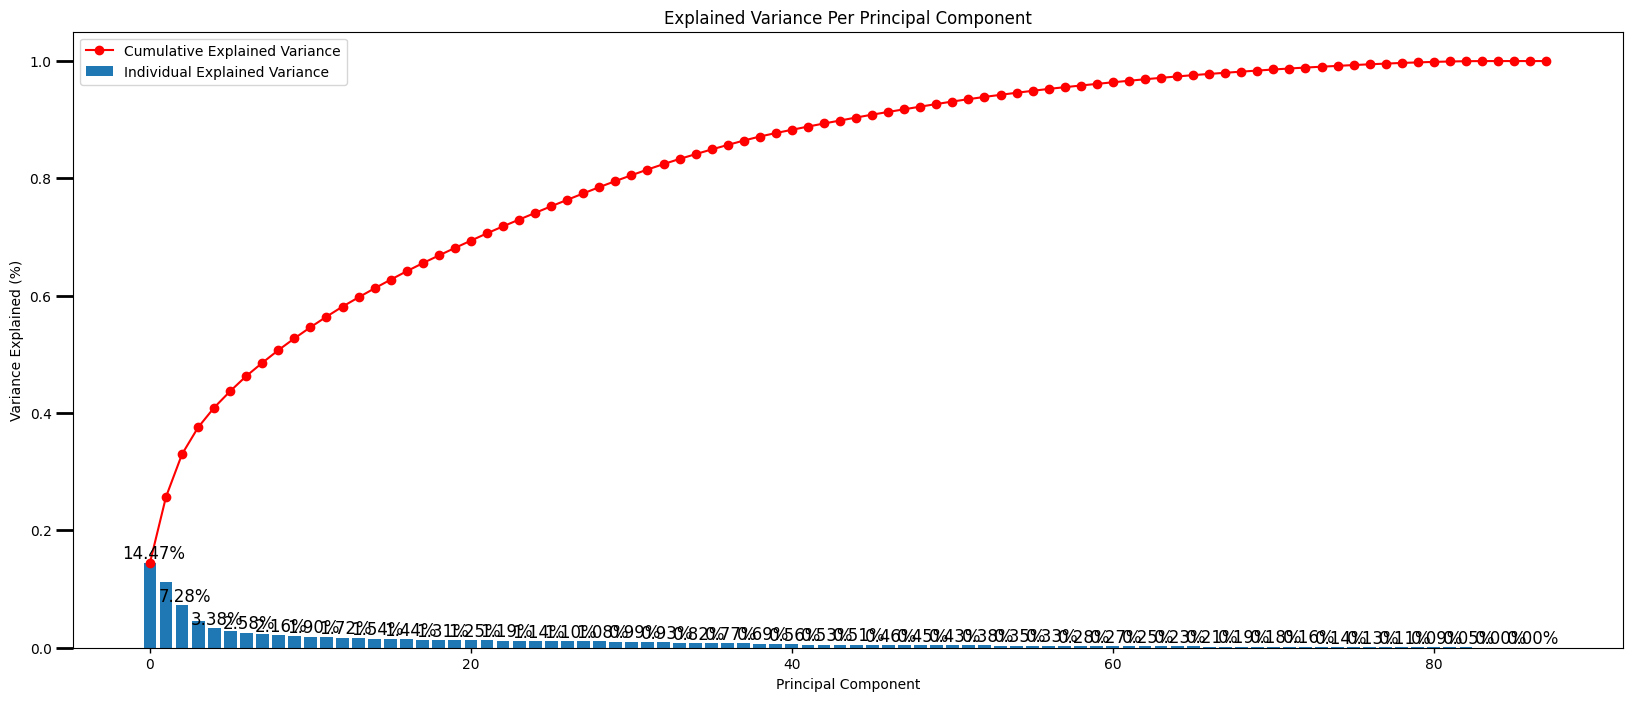

In [29]:
# Investigate the variance accounted for by each principal component.

def screen_plot(pca):
    # Get the number of components and the variance explained by each
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_

    # Create a figure and axis
    plt.figure(figsize=(20, 8))
    ax = plt.subplot(111)
    
    # Calculate the cumulative sum of the explained variances
    cumvals = np.cumsum(vals)
    
    # Plot the variance explained by each component
    ax.bar(ind, vals, label='Individual Explained Variance')
    
    # Plot the cumulative variance explained
    ax.plot(ind, cumvals, label='Cumulative Explained Variance', color='red', marker='o')

    # Annotate each bar with the percentage of variance explained
    for i in range(num_components):
        if i % 2 == 0:  # To avoid too many annotations
            ax.annotate(f"{vals[i] * 100:.2f}%", (ind[i] + 0.2, vals[i]), va="bottom", ha="center", fontsize=12)

    # Customize the axis labels, title, and ticks
    ax.xaxis.set_tick_params(width=1)
    ax.yaxis.set_tick_params(width=2, length=12)
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    ax.set_title("Explained Variance Per Principal Component")
    
    # Show the legend
    ax.legend()

    # Show the plot
    plt.show()

# Example usage:
screen_plot(pca)



number of components 44


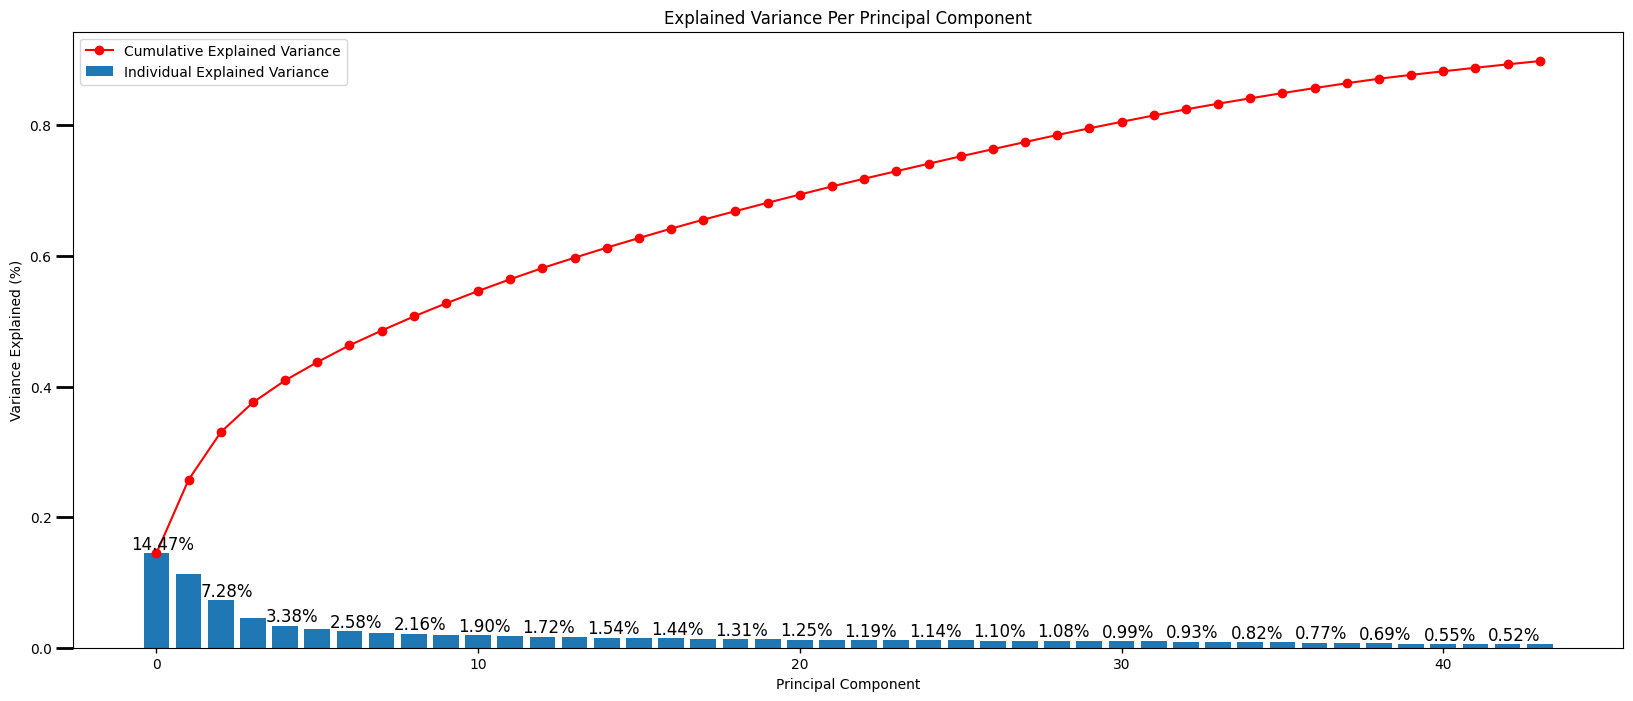

In [30]:
# Re-apply PCA to the data while selecting for number of components to retain.
n_comp = len(np.where(np.cumsum(pca.explained_variance_ratio_)<=0.90)[0])

print(f'number of components {n_comp}')
pca = PCA(n_components = n_comp)
azdias_pca = pca.fit_transform(new_azdias)
screen_plot(pca)



### Discussion 2.2: Perform Dimensionality Reduction

using 44 components we can get up to 90% of variance explained, so I choose to keep only the 44 significant features 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [31]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def get_weights(pca, i, col_name):
    weights = pca.components_[i]
    idx_sorted_weights = np.argsort(weights)[::-1]
    d = {}
    # sort the values
    for i in range(len(weights)):
        idx = idx_sorted_weights[i]
        d[col_name[idx]] = weights[idx]
    
    return pd.DataFrame(d, index=[0])
sorted_weights_c1 = get_weights(pca, 0, columns_name)
sorted_weights_c1



,LP_STATUS_GROB_1.0,PLZ8_ANTG3,PLZ8_ANTG4,HH_EINKOMMEN_SCORE,WEALTH,KBA05_BAUMAX,ORTSGR_KLS9,EWDICHTE,FINANZ_HAUSBAUER,KBA05_ANTG4,FINANZ_SPARER,PLZ8_ANTG2,ARBEIT,KBA05_ANTG3,ANZ_HAUSHALTE_AKTIV,RELAT_AB,SEMIO_PFLICHT,SEMIO_REL,DECADE,SEMIO_RAT,SEMIO_TRADV,LP_FAMILIE_GROB_1.0,GEBURTSJAHR,SEMIO_MAT,FINANZ_UNAUFFAELLIGER,SEMIO_FAM,REGIOTYP,FINANZ_ANLEGER,SEMIO_KULT,NATIONALITAET_KZ_2.0,OST_WEST_KZ_O,KKK,SHOPPER_TYP_2.0,PLZ8_HHZ,SEMIO_SOZ,ALTER_HH,SEMIO_KAEM,NATIONALITAET_KZ_3.0,W_KEIT_KIND_HH,ANZ_HH_TITEL,HEALTH_TYP,AGER_TYP,VERS_TYP,SEMIO_DOM,LP_FAMILIE_GROB_3.0,KK_KUNDENTYP,KBA05_ANTG2,SEMIO_KRIT,SHOPPER_TYP_1.0,ANREDE_KZ,TITEL_KZ,SOHO_KZ,ANZ_TITEL,LP_STATUS_GROB_2.0,SHOPPER_TYP_0.0,LP_FAMILIE_GROB_4.0,RETOURTYP_BK_S,LP_STATUS_GROB_3.0,LP_FAMILIE_GROB_2.0,SEMIO_VERT,SHOPPER_TYP_3.0,ONLINE_AFFINITAET,MIN_GEBAEUDEJAHR,OST_WEST_KZ_W,WOHNDAUER_2008,LP_FAMILIE_GROB_5.0,KBA13_ANZAHL_PKW,NATIONALITAET_KZ_1.0,SEMIO_ERL,SEMIO_LUST,ANZ_PERSONEN,GEBAEUDETYP_RASTER,FINANZ_VORSORGER,BALLRAUM,MOUVEMENT,GREEN_AVANTGARDE,ALTERSKATEGORIE_GROB,LIFE_STAGE,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,INNENSTADT,KONSUMNAEHE,PLZ8_GBZ,KBA05_GBZ,PLZ8_ANTG1,FINANZ_MINIMALIST,KBA05_ANTG1,MOBI_REGIO
0,0.20861,0.202532,0.197313,0.193851,0.190367,0.186114,0.173344,0.170909,0.151068,0.143776,0.137528,0.135025,0.127789,0.127675,0.127098,0.117075,0.104347,0.100135,0.100108,0.088919,0.08685,0.083078,0.081927,0.075821,0.07061,0.070296,0.066644,0.066339,0.064771,0.059654,0.05514,0.042067,0.040843,0.03729,0.036295,0.035988,0.034543,0.034077,0.033529,0.030095,0.029166,0.028788,0.021741,0.021261,0.010704,0.010702,0.009422,0.008327,0.00678,0.006706,-0.001409,-0.002023,-0.005766,-0.016529,-0.019238,-0.022065,-0.024009,-0.031513,-0.033631,-0.034843,-0.03861,-0.040675,-0.047711,-0.05514,-0.062999,-0.064327,-0.069816,-0.072126,-0.073484,-0.078983,-0.082874,-0.106253,-0.108314,-0.110007,-0.112028,-0.112362,-0.113897,-0.115138,-0.117405,-0.123587,-0.144037,-0.149458,-0.15115,-0.202569,-0.204053,-0.209722,-0.214114,-0.226305


In [32]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
sorted_weights_c2 = get_weights(pca, 1, columns_name)
print(sorted_weights_c2)


   ALTERSKATEGORIE_GROB  FINANZ_VORSORGER  SEMIO_ERL  SEMIO_LUST  \
0              0.239781          0.219442   0.204919    0.169892   

   RETOURTYP_BK_S  W_KEIT_KIND_HH  FINANZ_HAUSBAUER  SEMIO_KRIT  PLZ8_ANTG3  \
0        0.162313        0.130484          0.114066    0.100106    0.088152   

   SEMIO_KAEM  SHOPPER_TYP_3.0  PLZ8_ANTG4  EWDICHTE  ORTSGR_KLS9  \
0    0.087285         0.086093    0.084705  0.082913      0.08223   

   KBA05_BAUMAX    WEALTH  KBA05_ANTG4  ANREDE_KZ  NATIONALITAET_KZ_1.0  \
0      0.074807  0.071041      0.06902   0.067429              0.065663   

   FINANZ_MINIMALIST  LP_FAMILIE_GROB_1.0    ARBEIT  ANZ_HAUSHALTE_AKTIV  \
0           0.065486             0.064119  0.063718             0.059884   

   PLZ8_ANTG2  RELAT_AB  WOHNDAUER_2008  HH_EINKOMMEN_SCORE  SEMIO_DOM  \
0    0.058488  0.058223        0.054124            0.051974   0.047122   

   KBA05_ANTG3  LP_STATUS_GROB_1.0  LP_FAMILIE_GROB_2.0  OST_WEST_KZ_O  \
0     0.045091            0.039984    

In [33]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
sorted_weights_c3 = get_weights(pca, 2, columns_name)
sorted_weights_c3


,SEMIO_VERT,SEMIO_SOZ,SEMIO_FAM,SEMIO_KULT,FINANZ_MINIMALIST,SHOPPER_TYP_0.0,SEMIO_REL,RETOURTYP_BK_S,W_KEIT_KIND_HH,FINANZ_VORSORGER,SEMIO_MAT,ALTERSKATEGORIE_GROB,SEMIO_LUST,MOUVEMENT,GREEN_AVANTGARDE,SHOPPER_TYP_1.0,PLZ8_ANTG4,ORTSGR_KLS9,EWDICHTE,PLZ8_ANTG3,LP_FAMILIE_GROB_2.0,ARBEIT,LP_STATUS_GROB_5.0,KBA05_BAUMAX,WOHNDAUER_2008,KBA05_ANTG4,RELAT_AB,PLZ8_ANTG2,ANZ_HAUSHALTE_AKTIV,WEALTH,NATIONALITAET_KZ_2.0,LP_STATUS_GROB_3.0,KK_KUNDENTYP,LP_FAMILIE_GROB_1.0,VERS_TYP,OST_WEST_KZ_O,ANZ_HH_TITEL,NATIONALITAET_KZ_1.0,ANZ_TITEL,KBA05_ANTG3,LP_STATUS_GROB_4.0,PLZ8_HHZ,AGER_TYP,SOHO_KZ,TITEL_KZ,REGIOTYP,LP_FAMILIE_GROB_5.0,KBA05_ANTG2,LIFE_STAGE,MIN_GEBAEUDEJAHR,HEALTH_TYP,ANZ_PERSONEN,KKK,LP_STATUS_GROB_1.0,OST_WEST_KZ_W,HH_EINKOMMEN_SCORE,KBA13_ANZAHL_PKW,KBA05_ANTG1,LP_STATUS_GROB_2.0,KBA05_GBZ,LP_FAMILIE_GROB_4.0,MOBI_REGIO,GEBAEUDETYP_RASTER,BALLRAUM,PLZ8_GBZ,KONSUMNAEHE,INNENSTADT,NATIONALITAET_KZ_3.0,PLZ8_ANTG1,FINANZ_HAUSBAUER,SHOPPER_TYP_3.0,ONLINE_AFFINITAET,SEMIO_PFLICHT,LP_FAMILIE_GROB_3.0,SEMIO_TRADV,ALTER_HH,GEBURTSJAHR,FINANZ_UNAUFFAELLIGER,FINANZ_SPARER,DECADE,SHOPPER_TYP_2.0,FINANZ_ANLEGER,SEMIO_RAT,SEMIO_ERL,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,ANREDE_KZ
0,0.337882,0.264716,0.260821,0.244226,0.14006,0.135454,0.102246,0.099268,0.09397,0.076286,0.067048,0.050987,0.048603,0.043469,0.043129,0.042049,0.041301,0.040876,0.04005,0.040025,0.031326,0.030114,0.029889,0.02954,0.027019,0.026677,0.026309,0.025761,0.024468,0.024319,0.021004,0.020834,0.019156,0.018887,0.01815,0.015325,0.012343,0.010986,0.009894,0.006743,0.005423,0.004868,0.001841,0.000281,-0.000938,-0.005742,-0.009569,-0.009799,-0.01045,-0.01051,-0.011713,-0.013156,-0.014529,-0.014574,-0.015325,-0.019715,-0.020224,-0.023282,-0.024103,-0.024867,-0.026723,-0.028722,-0.029584,-0.030417,-0.034142,-0.03489,-0.037835,-0.03811,-0.041423,-0.04327,-0.045611,-0.049855,-0.050315,-0.055213,-0.05616,-0.07285,-0.072925,-0.073577,-0.078587,-0.088236,-0.11087,-0.16417,-0.189725,-0.191955,-0.269602,-0.309485,-0.335495,-0.36163


### Discussion 2.3: Interpret Principal Components
The three components capture distinct socio-economic and personality dynamics. The first component is positively associated with large families, wealth, and financial preparedness, while negatively linked to smaller households and limited family structures. The second component emphasizes age, financial habits, and personality, with a positive association to event-oriented and sensual-minded individuals, and a negative one with religious or money-saver types. The third component focuses on personality and social values, showing a positive connection to dreamful, socially-minded, and family-oriented individuals, while negatively associated with combative, dominant, and critical personalities.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [34]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans

def get_kmeans_score(data, center):

    kmeans = KMeans(n_clusters=center).fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(kmeans.score(data))
    
    return score

scores = []
clusters = list(range(4,20))

for k in clusters:
    scores.append(get_kmeans_score(azdias_pca, k))
    
    

Text(0.5, 1.0, 'SE vs. S')

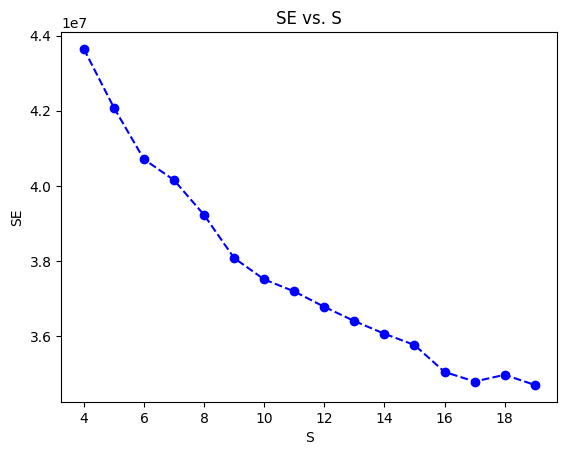

In [35]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(clusters, scores, linestyle='--', marker='o', color='b')
plt.xlabel('S')
plt.ylabel('SE')
plt.title('SE vs. S')

In [36]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
k = 10
kmeans = KMeans(n_clusters=k)
clusters = kmeans.fit_predict(azdias_pca)
clusters


array([0, 9, 1, ..., 1, 5, 6], dtype=int32)

### Discussion 3.1: Apply Clustering to General Population

I choose 10 clusters as the SE decreases with small amouts after that it start increase

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [40]:
# Load in the customer demographics data.
customer_data = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')
customer_data.head(4)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,0.0,1,3,11.0,3.0,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,0.0,2,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0,0.0,0.0,1,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,0.0,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0


In [95]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
# Get the feature names used during fitting
customers_cleaned = clean_data(customer_data)
customers_cleaned.shape
print(customers_cleaned.columns)
print(scaler.feature_names_in_) 

print(customers_cleaned.columns)
customers_cleaned.columns = customers_cleaned.columns.astype(str)
scaler.fit(customers_cleaned)
customers_cleaned_scaled = scaler.transform(customers_cleaned)
customers_cleaned = pd.DataFrame(customers_cleaned_scaled, columns=customers_cleaned.columns)


Index([ 'ALTERSKATEGORIE_GROB',             'ANREDE_KZ',
           'FINANZ_MINIMALIST',         'FINANZ_SPARER',
            'FINANZ_VORSORGER',        'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER',      'FINANZ_HAUSBAUER',
            'GREEN_AVANTGARDE',            'HEALTH_TYP',
              'RETOURTYP_BK_S',             'SEMIO_SOZ',
                   'SEMIO_FAM',             'SEMIO_REL',
                   'SEMIO_MAT',            'SEMIO_VERT',
                  'SEMIO_LUST',             'SEMIO_ERL',
                  'SEMIO_KULT',             'SEMIO_RAT',
                  'SEMIO_KRIT',             'SEMIO_DOM',
                  'SEMIO_KAEM',         'SEMIO_PFLICHT',
                 'SEMIO_TRADV',               'SOHO_KZ',
                    'VERS_TYP',          'ANZ_PERSONEN',
                   'ANZ_TITEL',    'HH_EINKOMMEN_SCORE',
              'W_KEIT_KIND_HH',        'WOHNDAUER_2008',
         'ANZ_HAUSHALTE_AKTIV',          'ANZ_HH_TITEL',
                 'KONSUMNAEHE',

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

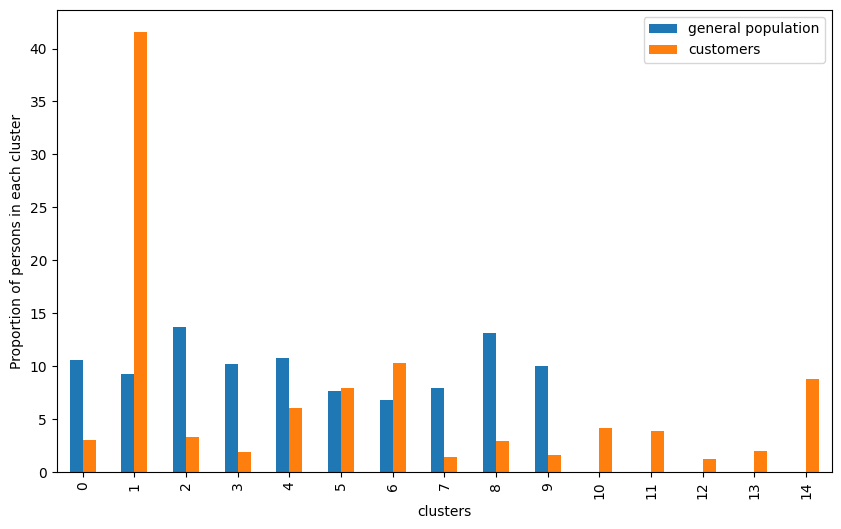

In [107]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
financial_columns = ['FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER']
customers_for_clustering = customers_cleaned[financial_columns]
kmeans = KMeans(n_clusters=15, random_state=42)  # Adjust number of clusters as needed
customers_cleaned['cluster'] = kmeans.fit_predict(customers_for_clustering)
centers = list(range(15))
general_population_proportion = []
customers_proportion = []

# Calculate proportions for general population and customers
for center in centers:
    general_population_proportion.append(np.sum(clusters == center) * 100 / len(clusters))  # No change needed here for clusters
    customers_proportion.append((customers_cleaned['cluster'] == center).sum() * 100 / len(customers_cleaned))  # Now use 'cluster'

# Create the DataFrame to compare proportions
df = pd.DataFrame({
    'clusters': centers,
    'general population': general_population_proportion,
    'customers': customers_proportion
})

# Plot the results
df.plot(x='clusters', y=['general population', 'customers'], kind='bar', figsize=(10, 6))
plt.ylabel('Proportion of persons in each cluster')
plt.show()

In [111]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

df['proportion_diff'] = df['customers'] - df['general population']

overrepresented_clusters = df[df['proportion_diff'] > 0]
print(overrepresented_clusters)

    clusters  general population  customers  proportion_diff
1          1            9.297926  41.568048        32.270122
5          5            7.628395   7.885960         0.257565
6          6            6.775407  10.329244         3.553837
10        10            0.000000   4.133346         4.133346
11        11            0.000000   3.889018         3.889018
12        12            0.000000   1.209650         1.209650
13        13            0.000000   1.971115         1.971115
14        14            0.000000   8.749354         8.749354


In [113]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
# Calculate the difference between customer and general population proportions for each cluster
df['proportion_diff'] = df['customers'] - df['general population']

# Identify clusters with a negative proportion difference (underrepresented)
underrepresented_clusters = df[df['proportion_diff'] < 0]
print(underrepresented_clusters)



   clusters  general population  customers  proportion_diff
0         0           10.578756   2.985902        -7.592853
2         2           13.660858   3.290938       -10.369920
3         3           10.213453   1.896917        -8.316535
4         4           10.790336   6.082727        -4.707610
7         7            7.927189   1.441238        -6.485951
8         8           13.139989   2.962669       -10.177321
9         9            9.987691   1.603873        -8.383818


In [115]:
underrepresented_cluster_labels = underrepresented_clusters['clusters']
underrepresented_customers = customers_cleaned[customers_cleaned['cluster'].isin(underrepresented_cluster_labels)]
# Summary statistics of underrepresented customers
underrepresented_customers.describe()

# Example
underrepresented_customers[['FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER']].head()


,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER
3,-1.252296,-0.505195,-0.701114
8,0.717421,0.719290,-0.701114
10,0.717421,0.719290,-0.701114
16,-2.237155,3.168261,-3.112380
17,-1.252296,0.719290,-0.701114


<Axes: xlabel='FINANZ_MINIMALIST', ylabel='Count'>

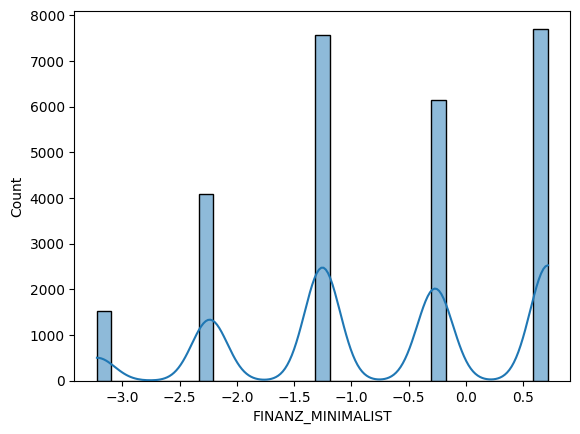

In [116]:
import seaborn as sns
sns.histplot(underrepresented_customers['FINANZ_MINIMALIST'], kde=True)

### Discussion 3.3: Compare Customer Data to Demographics Data

In this analysis, we compared customer data with general demographic data to identify segments of the population that are overrepresented or underrepresented among the customers of the mail-order company. We found that certain clusters, such as those associated with higher financial stability or specific regional and lifestyle preferences, are more popular with the company, as evidenced by their higher proportion in the customer data compared to the general population. On the other hand, clusters characterized by lower income levels, younger age groups, or specific regional areas were underrepresented in the customer data, suggesting that the company may be overlooking these segments. These insights could inform targeted marketing efforts and product offerings aimed at reaching underrepresented populations, potentially expanding the customer base.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.